In [2]:
import sympy as sp
from sympy import *
init_printing()

# Coordinates and 3+1 metric

In [22]:
'''
Define coordinates
'''

r, theta, phi = symbols('r, theta, phi')
h = Function('h')(theta, phi)
N = symbols('N')
M = symbols('M')
R = symbols('R')

coords = [r, theta, phi]

In [23]:
'''
Input: 3+1 formalism: alpha, beta and gamma
*To do: function which gives 3+1 components from general metric*
'''

alpha = sp.sqrt(1 - 2*M/r)
beta = Array([0, 0, 0])

g_11 = 1 / (1 - 2*M/r)
g_12 = 0
g_13 = 0
g_22 = r**2
g_23 = 0
g_33 = r**2 * (sp.sin(theta))**2

gamma = Matrix([[g_11, g_12, g_13], [g_12, g_22, g_23], [g_13, g_23, g_33]])



'''
Calculate inverse
'''

gamma_inv = gamma**(-1)


#
#beta = sp.MutableDenseNDimArray.zeros(len(coords))
#for i in range(len(coords)):
#    beta[[i]] = sum([gamma_inv[i, j] * beta_d[j] for j in range(len(coords))])



#alpha = sp.simplify(sp.sqrt((1-2*M/r) - sum(beta[i] * beta_d[i] for i in range(len(coords)))))

# Normal vectors

Normal vector is defined as $$n^{\mu} = \frac{1}{\alpha} (1, -\beta^i)$$

In [24]:
'''
Normal 3-vector to hypersurface n_i
'''

# Normal 3-vector with index down
def normal_up(alpha, beta, coords):
    dim = len(coords)
    n = sp.MutableDenseNDimArray.zeros(dim)
    for i in range(dim):
        n[[i]] = - 1/alpha * beta[i]
    return n

# Normal 3-vector with index up contracted with spatial metric
def normal_down(alpha, beta, gamma, coords):
    dim = len(coords)
    n_up = normal_up(alpha, beta, coords)
    n = sp.MutableDenseNDimArray.zeros(dim)
    for i in range(dim):
        n[[i]] = sum([gamma[i, j] * n_up[j] for j in range(dim)])
    return n

n_up = normal_up(alpha, beta, coords)
n_down = normal_down(alpha, beta, gamma, coords)

display(n_up, n_down)

# Christoffel symbols

Calculating from the formula $$\Gamma^{i}_{jk} = \frac{1}{2} \gamma^{ia} (\partial_{j}\gamma_{ka} + \partial_{k}\gamma_{ja} - \partial_{a}\gamma_{jk})$$

In [25]:
'''
Christoffel symbols
'''
def christoffel_symbols(g, g_inv, coords):
    n = len(coords)
    Gamma = sp.MutableDenseNDimArray.zeros(n, n, n)
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                Gamma[k, i, j] = 0.5 * sum([g_inv[k, l] * (sp.diff(g[l, j], coords[i]) + 
                                                           sp.diff(g[l, i], coords[j]) - 
                                                           sp.diff(g[i, j], coords[l])) for l in range(n)])
    return Gamma

# Calculate the Christoffel symbols
christoffel = christoffel_symbols(gamma, gamma_inv, coords)

# Vector s

Vector $s$ given by $$s_i = \lambda (1, -\partial_{\theta}h, \partial_{\phi}h)$$ with $\lambda$ a normalization factor such that $$s_i s^i = 1$$

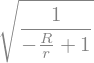

In [26]:
'''
Spacelike outward-pointing vector s
'''

n = len(coords)
s = Array([1, 0, 0])
#s = Array([1, -diff(h, theta), 0])
#s = Array([1, -diff(h, theta), -diff(h, phi)])
s_inv = sp.MutableDenseNDimArray.zeros(n)
for i in range(n):
    s_inv[[i]] = sum([gamma_inv[i, j] * s[j] for j in range(n)])
norm = 1 / (sum(s[i] * s_inv[i] for i in range(n)))
N = sp.sqrt(norm)
s_norm = N * s
s_inv_norm = sp.MutableDenseNDimArray.zeros(n)
for i in range(n):
    s_inv_norm[[i]] = sum([gamma_inv[i, j] * s_norm[j] for j in range(n)])

display(N)

# Extrinsic curvature

Calculating from the formula $$K_{ij} = \gamma_i^a \gamma_j^b \nabla_a n_b$$ where $$\gamma_i^a = \delta_i^a + n^a n_i$$

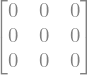

In [27]:
'''
Extrinsic Curvature
'''

def extrinsic_curvature(n_up, n_down, christoffel, coords):
    n = len(coords)
    delta = eye(n)
    K = sp.MutableDenseNDimArray.zeros(n, n)
    for i in range(n):
        for j in range(n):
            K[i, j] = sum(sum((delta[i, a] + n_up[a]*n_down[i]) * (delta[j, b] + n_up[b]*n_down[j]) * (diff(n_down[b], coords[a]) -
                      sum(christoffel[k, a, b]*n_down[k] for k in range(n))) for b in range(n)) for a in range(n))
    return K

cur = extrinsic_curvature(n_up, n_down, christoffel, coords)
display(sp.simplify(cur))

# Expansion equation (symbolic)

The expansion equation is $$\Theta = \nabla_i s^i + s^i s^j K_{ij} - K = 0$$ \
We assume maximal slicing condition such that $$K = 0$$

In [28]:
'''
Expansion function
'''

# First term
def cov_derivative(christoffel, s, coords):
    n = len(coords)
    cov_dev = sum(diff(s[i], coords[i]) for i in range(n)) + sum(sum(christoffel[i, i, j] * s[j] for j in range(n)) for i in range(n))
    return cov_dev

# Second term
def curv(ext_curv, s, coords):
    n = len(coords)
    curv = sum(sum(ext_curv[i, j] * s[i] * s[j] for j in range(n)) for i in range(n))
    return curv

'''
# Third term
def trace_curv(gamma_inv, ext_curv, coords):
    n = len(coords)
    trace = sum(sum(gamma_inv[i, j] * ext_curv[i, j] for j in range(n)) for i in range(n))
    return trace
'''

# Full equation
def expansion(christoffel, s, ext_curv, gamma_inv):
    return (cov_derivative(christoffel, s, coords) + curv(ext_curv, s, coords) #- trace_curv(gamma_inv, ext_curv, coords))

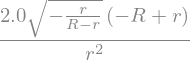

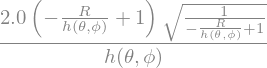

In [30]:
test = expansion(christoffel, s_inv_norm, cur, gamma_inv)
display(simplify(test))
display(test.subs(r, h))